# Convolutional Networks

For the theory behind this model, see the [Stanford class: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/)

## 1. Data Preparation

Download the [cats and dogs dataset](https://www.kaggle.com/c/dogs-vs-cats/data) from Kaggle or from here:

!wget https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip

In [1]:
import os
import shutil

import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

In [2]:
# import tensorflow
# tensorflow.__version__  # 2.6.0

Create a train and validation folders. In each folder, create cats and dogs folders

In [3]:
if False: # this and the next 2 cells should be run only once, set 'False' to 'True'
    train_dir = './cats_dogs/train'
    val_dir = './cats_dogs/val'

    dog_train_dir = './cats_dogs/train/dog'
    dog_val_dir = './cats_dogs/val/dog'
    cat_train_dir = './cats_dogs/train/cat'
    cat_val_dir = './cats_dogs/val/cat'

    file_dirs = [train_dir, val_dir, dog_train_dir, dog_val_dir, cat_train_dir, cat_val_dir]

    for dir in file_dirs:
        os.makedirs(dir,exist_ok = True)
    
    print(len(os.listdir(train_dir)))
    print(len(os.listdir(val_dir)))

Move the first 10,000 images to the train folder (from 0 to 9999) for boths cats and dogs - and put them in respective folders. Move the remaining 2,500 images to the validation folder (from 10000 to 12499)

In [4]:
# Move the first 10,000 images to the train folder (from 0 to 9999) for boths cats and dogs in respective folders
if False:
    source_folder = './cats_dogs/train/'
    destination_folder = './cats_dogs/train/'

    # iterate files
    for spc in ['dog','cat']:
        for num in range(0,10000):
            # construct full file path
            source = source_folder + '{}.{}.jpg'.format(spc,num)
            destination = destination_folder + '{}/'.format(spc) + '{}.{}.jpg'.format(spc,num)
            # move file
            shutil.move(source, destination)
            # print('Moved:', '{}.{}.jpg'.format(spc,num)) 
    print(len(os.listdir(train_dir)))

In [5]:
# Move the remaining 2500 images to the val folder (from 10000 to 12499) for boths cats and dogs
if False:
    source_folder = './cats_dogs/train/'
    destination_folder = './cats_dogs/val/'

    # iterate files
    for spc in ['dog','cat']:
        for num in range(10000,12500):
            # construct full file path
            source = source_folder + '{}.{}.jpg'.format(spc,num)
            destination = destination_folder + '{}/'.format(spc) + '{}.{}.jpg'.format(spc,num)
            # move file
            shutil.move(source, destination)
            print('Moved:', '{}.{}.jpg'.format(spc,num))
    
    print(len(os.listdir(train_dir)))

## 2. Model

We use a Convolutional Neural Network (CNN) in Keras. This is the model structure:


* The shape for input should be `(150, 150, 3)`
* Create a convolutional layer ([`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling ([`MaxPooling2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Add a `Dense` layer with 64 neurons and `'relu'` activation
* Create the `Dense` layer with 1 neuron - this will be the output
    * The output layer should have an activation - sigmoid is the appropiate for the binary classification case ([Ref](https://ecwuuuuu.com/post/sigmoid-softmax-binary-class/))

As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:

* `SGD(learning_rate=0.002, momentum=0.8)`

In [6]:
def make_model(input_size=150, size_inner=64):#,droprate=0.5):

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    conv = keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(input_size, input_size, 3))(inputs)
    
    tensors = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    vectors = keras.layers.Flatten()(tensors)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    # drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(1, activation='sigmoid')(inner) #(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.SGD(learning_rate=0.002, momentum=0.8)
    loss = keras.losses.BinaryCrossentropy(from_logits=False) # activation in output layer, no need from_logits=True

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [7]:
make_model().summary()

2021-11-24 15:25:03.829671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-24 15:25:03.829735: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 15:25:03.829776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (granada): /proc/driver/nvidia/version does not exist
2021-11-24 15:25:03.831158: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                11214912  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 11,215,873
Trainable params: 11,215,873
Non-trainable params: 0
_________________________________________________

Since we have a binary classification problem, we used BinaryCrossentropy as loss function.

The model has 11 215 873 parameters.

### Generators and Training

We use the following data generator for both train and validation:

```python
ImageDataGenerator(rescale=1./255)
```
* We don't need to do any additional pre-processing for the images.
* we use `class_mode = binary`, `batch_size=20` and `shuffle=True` for both training and validaition 

In [8]:
# TRAIN
train_dir = './cats_dogs/train' # in case the corresponding cell above is set False
train_gen = image.ImageDataGenerator(rescale=1./255)
train_ds = train_gen.flow_from_directory(
            train_dir,
            batch_size=20,
            class_mode='binary',
            target_size=(150, 150),
            shuffle=True  # True is the default value
)
train_ds.class_indices # OHE

Found 20000 images belonging to 2 classes.


{'cat': 0, 'dog': 1}

In [9]:
# VAL
val_dir = './cats_dogs/val' # in case the corresponding cell above is set False
val_gen = image.ImageDataGenerator(rescale=1./255)
val_ds = val_gen.flow_from_directory(
            val_dir,
            batch_size = 20,
            class_mode = 'binary',
            target_size=(150, 150),
            shuffle=True # True is the default value
)
val_ds.class_indices # OHE

Found 5000 images belonging to 2 classes.


{'cat': 0, 'dog': 1}

We train with `.fit()` with the following params:

```python
model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)
```

The parameter `validation_steps=50` says "run only 50 steps on the validation data for evaluating the results". If we do not specify it, the model will see all the dataset in each epoch. One step for us is a batch of 20 images, for us one epoch is when the model see 2000 images. As the steps per epoch is 100 and we have 10 000 images, the model needs 5 epochs to see the complete dataset (note: if we do not shuffle the data). This way we iterate a bit faster, but don't use the entire validation dataset in each epoch. That's why it's important to shuffle the validation dataset as well (we specify it in the parameters but actually it is the default).

In [10]:
# Fit data to model  (10 epochs took about 6min)
model = make_model()
history = model.fit(
            train_ds,
            steps_per_epoch=100,
            epochs=10,
            validation_data=val_ds,
            validation_steps=50
            )

2021-11-24 15:25:05.824467: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
100/100 [==============================] - 35s 339ms/step - loss: 0.6977 - accuracy: 0.5315 - val_loss: 0.6888 - val_accuracy: 0.5560
Epoch 2/10
100/100 [==============================] - 34s 342ms/step - loss: 0.6845 - accuracy: 0.5675 - val_loss: 0.6804 - val_accuracy: 0.5740
Epoch 3/10
100/100 [==============================] - 34s 340ms/step - loss: 0.6780 - accuracy: 0.5735 - val_loss: 0.6714 - val_accuracy: 0.5820
Epoch 4/10
100/100 [==============================] - 35s 346ms/step - loss: 0.6719 - accuracy: 0.5790 - val_loss: 0.6574 - val_accuracy: 0.6000
Epoch 5/10
100/100 [==============================] - 34s 337ms/step - loss: 0.6581 - accuracy: 0.6060 - val_loss: 0.6626 - val_accuracy: 0.5890
Epoch 6/10
100/100 [==============================] - 33s 332ms/step - loss: 0.6543 - accuracy: 0.6140 - val_loss: 0.6566 - val_accuracy: 0.6090
Epoch 7/10
100/100 [==============================] - 34s 335ms/step - loss: 0.6462 - accuracy: 0.6125 - val_loss: 0.6545 - val_ac

The median of training accuracy for this model is:

In [11]:
np.median(history.history['accuracy']).round(2)

0.61

The standard deviation of training loss for this model is:

In [12]:
np.std(history.history['loss']).round(2)

0.02

### Visualization of the performance metrics

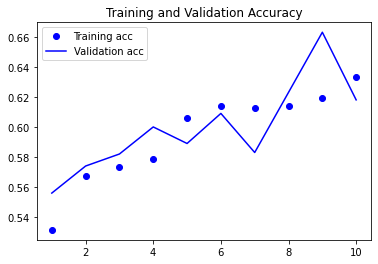

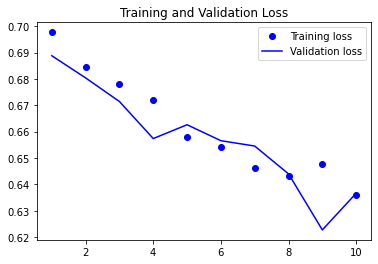

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## 3. Data Augmentation

We'll now generate more data using data augmentations and train the previous model on this new data too to check if the accuracy increases. 

We add the following augmentations to the training data generator:

* `rotation_range=40,` i.e., each time the model sees an image, it will be rotated by a randomn no. of degrees between -40 and 40
* `width_shift_range=0.2,`, i.e., each time the model sees an image, it will be shifted widthly by a randomn no. between -0.2 and 0.2
* `height_shift_range=0.2,`, i.e., each time the model sees an image, its high will be shifted by a randomn no. between -0.2 and 0.2
* `shear_range=0.2,`, i.e., each time the model sees an image, it will be sheared by a randomn no. between -0.2 and 0.2
* `zoom_range=0.2,`, i.e., each time the model sees an image, its high will be zoomed by a randomn no. between -0.2 and 0.2
* `horizontal_flip=True,`
* `fill_mode='nearest'`

The model was previously trained on the original train dataset, now on the new dataset, so 50% of the images the model will have seen are original.

In [14]:
# TRAIN
train_dir = './cats_dogs/train' # in case the corresponding cell above is set False
train_gen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, # takes the range [-30, 30] and rotates each image randomly in that range
    width_shift_range=0.2, # shift the image on a specific axis in the range [-10, 10].
    height_shift_range=0.2, # shift the image on a specific axis in the range [-10, 10].
    shear_range=0.2, # distort the image on a specific axis in the range [-10, 10])
    zoom_range=0.2, # ndicates the amount of change, so 0.1 means the range will be [0.9, 1.1].
    horizontal_flip=True,
    fill_mode='nearest'
)

Let us see how the new data look like

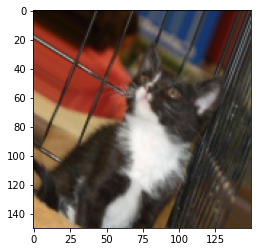

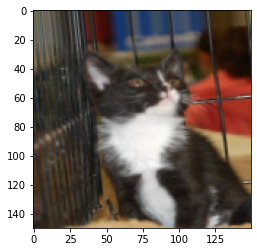

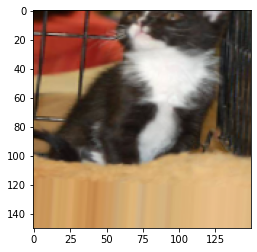

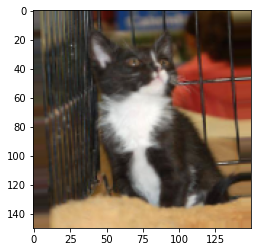

In [15]:
fnames = [os.path.join(train_dir+"/cat", fname) for
    fname in os.listdir(train_dir+"/cat")]

img_path = fnames[0]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i=0
for batch in train_gen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [16]:
train_ds = train_gen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150, 150),
    shuffle=True
)

Found 20000 images belonging to 2 classes.


Let's train our model for 10 more epochs using the same code as previously. We don't re-create the model - we want to continue training the model we already started training. We don't need to recompile it. But even if you compile again, it doesn't reset the model you trained previously (re-running the cell where we defined the model will change it, tough).

In [17]:
# Fit data to model  (10 epochs took about 6min) 
model = make_model()
history = model.fit(
            train_ds,
            steps_per_epoch=100,
            epochs=10,
            validation_data=val_ds,
            validation_steps=50
            )

Epoch 1/10
100/100 [==============================] - 49s 479ms/step - loss: 0.7097 - accuracy: 0.5005 - val_loss: 0.6925 - val_accuracy: 0.5170
Epoch 2/10
100/100 [==============================] - 47s 467ms/step - loss: 0.6923 - accuracy: 0.5150 - val_loss: 0.6910 - val_accuracy: 0.5220
Epoch 3/10
100/100 [==============================] - 45s 453ms/step - loss: 0.6903 - accuracy: 0.5275 - val_loss: 0.6819 - val_accuracy: 0.5700
Epoch 4/10
100/100 [==============================] - 47s 472ms/step - loss: 0.6872 - accuracy: 0.5410 - val_loss: 0.6850 - val_accuracy: 0.5380
Epoch 5/10
100/100 [==============================] - 49s 492ms/step - loss: 0.6853 - accuracy: 0.5550 - val_loss: 0.6810 - val_accuracy: 0.5600
Epoch 6/10
100/100 [==============================] - 46s 457ms/step - loss: 0.6841 - accuracy: 0.5495 - val_loss: 0.6720 - val_accuracy: 0.5950
Epoch 7/10
100/100 [==============================] - 49s 484ms/step - loss: 0.6811 - accuracy: 0.5555 - val_loss: 0.6730 - val_ac

The mean of validation loss for the model trained with augmentations is:

In [18]:
np.mean(history.history['val_loss']).round(2) # 0.68

0.68

The average of validation accuracy for the last 5 epochs (from 6 to 10) for the model trained with augmentations is:

In [19]:
np.average(history.history['val_accuracy'][6:10]).round(3) # 0.57

0.576

In [20]:
np.average(history.history['val_accuracy'][5:10]).round(3)

0.58

The performance is a bit better after training the model with the augmented dataset. Still, it is slightly better than a random choice. To improve the model performance we could:
* collect more images, 
* tune the hyperparameters and/or 
* use a pre-trained model as base-model (as Xception using MageNet).